Updating the numbers from this story: 

https://highline.huffingtonpost.com/articles/en/poor-millennials/

BOOMER -- 306

MILLENNIAL -- 4459

Hours of minimum wage work needed to pay for four years of public college
Source: National Center for Education Statistics. Calculations based on tuition for four-year public universities from 1973-1976 and 2003-2006.


Note: the most up-to-date tables don't break down colleges vs universities, and there doesn't seem to be any good reason to distinguish between the two in this context, so we will be using all 4-year public institutions with current dollars. 

SOURCES: 

"Table 330.10.	Average undergraduate tuition and fees and room and board rates charged for full-time students in degree-granting postsecondary institutions, by level and control of institution: Selected years, 1963-64 through 2017-18"
https://nces.ed.gov/programs/digest/d18/tables/dt18_330.10.asp?current=yes

https://fred.stlouisfed.org/series/FEDMINNFRWG



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

In [2]:
# load the tuition data
data = pd.read_csv("4_year_public_tuition.csv")
data.head()

#load the UNIVERSITY ONLY data for testing purposes
#data = pd.read_csv("4_year_public_tuition_universities.csv")
#data.head()

,starting_year,tuition_and_fees
0,1966,302.362429
1,1967,310.074436
2,1968,321.002362
3,1969,358.354831
4,1970,393.688558


In [3]:
#Add 12 months for each year
data_months = data.loc[data.index.repeat(12)].reset_index()
data_months["old_index"] = data_months["index"]
data_months = data_months[["starting_year","tuition_and_fees","old_index"]]
data_months.head()

,starting_year,tuition_and_fees,old_index
0,1966,302.362429,0
1,1966,302.362429,0
2,1966,302.362429,0
3,1966,302.362429,0
4,1966,302.362429,0


In [4]:
#Add a sequential index for each month
data_months["month_count"] = data_months.index%12+1
data_months.head()

,starting_year,tuition_and_fees,old_index,month_count
0,1966,302.362429,0,1
1,1966,302.362429,0,2
2,1966,302.362429,0,3
3,1966,302.362429,0,4
4,1966,302.362429,0,5


In [5]:
#Split the annual fees into 12 portions, create true month and year columns by shifting to start the years in June, create a join key
data_months["tuition_monthly"] = data_months["tuition_and_fees"]/12
data_months["true_month"] = data_months["month_count"].shift(-5)
data_months["true_year"] = data_months["starting_year"].shift(-5)
data_months.dropna(axis=0, subset=["true_month", "true_year"], inplace=True)
data_months["month_year"] = data_months["true_month"].astype(int).astype(str) + "_" + data_months["true_year"].astype(int).astype(str)
data_months.head()

,starting_year,tuition_and_fees,old_index,month_count,tuition_monthly,true_month,true_year,month_year
0,1966,302.362429,0,1,25.196869,6.0,1966.0,6_1966
1,1966,302.362429,0,2,25.196869,7.0,1966.0,7_1966
2,1966,302.362429,0,3,25.196869,8.0,1966.0,8_1966
3,1966,302.362429,0,4,25.196869,9.0,1966.0,9_1966
4,1966,302.362429,0,5,25.196869,10.0,1966.0,10_1966


In [6]:
#Load the FRED minimum wage by month data
minimum_data = pd.read_csv("FEDMINNFRWG.csv")
minimum_data.head()

,DATE,FEDMINNFRWG,month_year
0,10/1/38,0.25,10_1938
1,11/1/38,0.25,11_1938
2,12/1/38,0.25,12_1938
3,1/1/39,0.25,1_1939
4,2/1/39,0.25,2_1939


In [7]:
#merge the two by the month year key
data_months_combined = pd.merge(data_months, minimum_data, how="left", on="month_year")
data_months_combined.head()

,starting_year,tuition_and_fees,old_index,month_count,tuition_monthly,true_month,true_year,month_year,DATE,FEDMINNFRWG
0,1966,302.362429,0,1,25.196869,6.0,1966.0,6_1966,6/1/66,1.25
1,1966,302.362429,0,2,25.196869,7.0,1966.0,7_1966,7/1/66,1.25
2,1966,302.362429,0,3,25.196869,8.0,1966.0,8_1966,8/1/66,1.25
3,1966,302.362429,0,4,25.196869,9.0,1966.0,9_1966,9/1/66,1.25
4,1966,302.362429,0,5,25.196869,10.0,1966.0,10_1966,10/1/66,1.25


In [8]:
#Get the number of hours worked each month at the minimum wage to earn tuition for that month
data_months_combined["monthly_hours"] = data_months_combined["tuition_monthly"]/data_months_combined["FEDMINNFRWG"]
data_months_combined.head()

,starting_year,tuition_and_fees,old_index,month_count,tuition_monthly,true_month,true_year,month_year,DATE,FEDMINNFRWG,monthly_hours
0,1966,302.362429,0,1,25.196869,6.0,1966.0,6_1966,6/1/66,1.25,20.157495
1,1966,302.362429,0,2,25.196869,7.0,1966.0,7_1966,7/1/66,1.25,20.157495
2,1966,302.362429,0,3,25.196869,8.0,1966.0,8_1966,8/1/66,1.25,20.157495
3,1966,302.362429,0,4,25.196869,9.0,1966.0,9_1966,9/1/66,1.25,20.157495
4,1966,302.362429,0,5,25.196869,10.0,1966.0,10_1966,10/1/66,1.25,20.157495


In [9]:
#Get the trailing sum of 48 months worth of hours worked
data_months_combined["hours_in_last_48_months"] = data_months_combined["monthly_hours"].rolling(48, min_periods=48).sum()
#Add a coerced date column for charting
data_months_combined["coerced_date"] = pd.to_datetime(data_months_combined['DATE'], errors = 'coerce')
data_months_combined.head()

,starting_year,tuition_and_fees,old_index,month_count,tuition_monthly,true_month,true_year,month_year,DATE,FEDMINNFRWG,monthly_hours,hours_in_last_48_months,coerced_date
0,1966,302.362429,0,1,25.196869,6.0,1966.0,6_1966,6/1/66,1.25,20.157495,NaN,2066-06-01
1,1966,302.362429,0,2,25.196869,7.0,1966.0,7_1966,7/1/66,1.25,20.157495,NaN,2066-07-01
2,1966,302.362429,0,3,25.196869,8.0,1966.0,8_1966,8/1/66,1.25,20.157495,NaN,2066-08-01
3,1966,302.362429,0,4,25.196869,9.0,1966.0,9_1966,9/1/66,1.25,20.157495,NaN,2066-09-01
4,1966,302.362429,0,5,25.196869,10.0,1966.0,10_1966,10/1/66,1.25,20.157495,NaN,2066-10-01


In [10]:
#export
data_months_combined.to_csv("running_monthly.csv")

[(717337.0, 737060.0)]

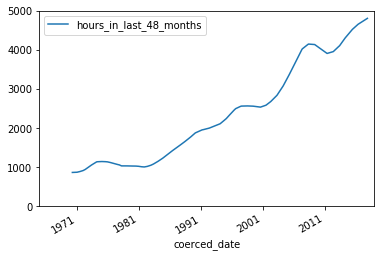

In [11]:
#plot all data
plot = data_months_combined[['coerced_date','hours_in_last_48_months']].set_index('coerced_date').plot()
plot.set(ylim=(0, None))
plot.set(xlim=(datetime.date(1965, 1, 1), datetime.date(2019, 1, 1)))

In [12]:
data_months_combined[data_months_combined["starting_year"] == 1976]["hours_in_last_48_months"].tail(1)

131    1083.637091
Name: hours_in_last_48_months, dtype: float64

In [13]:
data_months_combined[data_months_combined["starting_year"] == 2006]["hours_in_last_48_months"].tail(1)

491    4005.871123
Name: hours_in_last_48_months, dtype: float64

In [14]:
data_months_combined[data_months_combined["starting_year"] == 2016]["hours_in_last_48_months"].tail(1)

611    4750.070528
Name: hours_in_last_48_months, dtype: float64

In [15]:
data_months_combined[data_months_combined["starting_year"] == 2017]["hours_in_last_48_months"].tail(1)

618    4808.418967
Name: hours_in_last_48_months, dtype: float64